In [140]:
import pickle
import warnings
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from collections import deque
import numpy as np
from matplotlib import cm, pyplot as plt


In [3]:
import pandas as pd
import os
init_dir_path = str(os.getcwd())  # find current working directory
stock_path=init_dir_path+'/stock_data/aapl_prices.csv'

In [58]:
end_time=5005
s=pd.read_csv(stock_path)
s=s.drop(['High','Low','Volume'],axis=1)
s['Return']=100*(s['Close']-s['Open'])/s['Open']
s['Volatility']=s['Return'].rolling(window=5).std()
s['Date']=pd.to_datetime(s['Date'])
#Leave some data for later testing
s=s.iloc[5:end_time]
s[['Return','Volatility']]=StandardScaler().fit_transform(s[['Return','Volatility']])

In [137]:
def plot_in_sample_hidden_states(hmm_model, df, features):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    rets = df[features]
    hidden_states = hmm_model.predict(rets)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot(
            df.index[mask], 
            df["Close"][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title(f"Hidden State #{i}")
        # ax.xaxis.set_major_locator(HourLocator(interval=1))  # Major ticks at every hour
        # ax.xaxis.set_minor_locator(MinuteLocator(interval=15))  # Minor ticks every 15 minutes
        ax.grid(True)
    plt.show()

/home/srijan/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


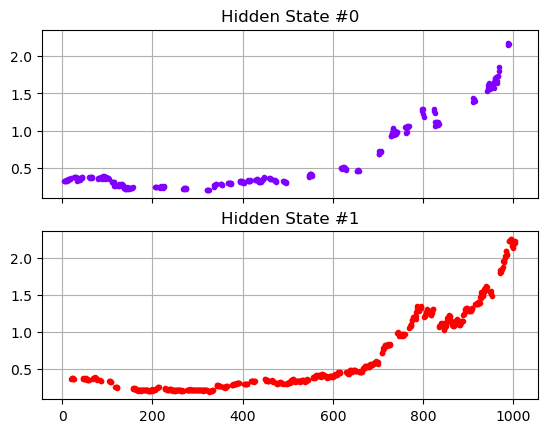

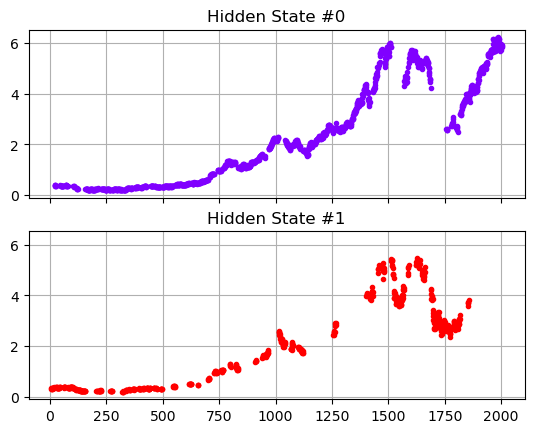

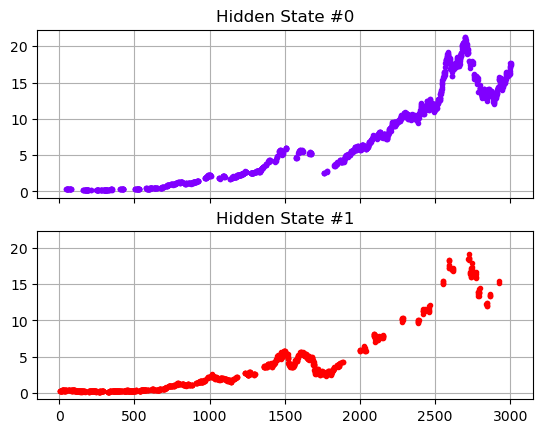

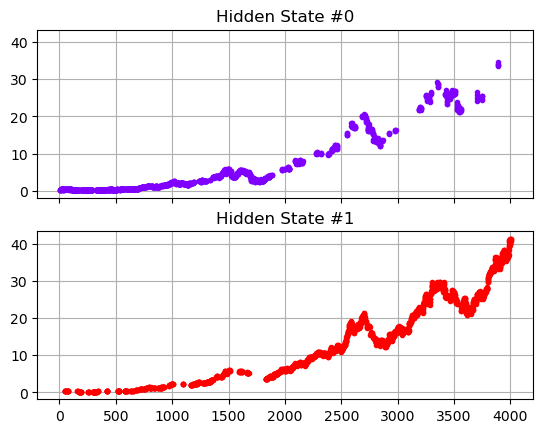

In [158]:
features=['Return','Volatility']
split_sets=np.array_split(s,1)
n_splits=4
d={}
tss=TimeSeriesSplit(n_splits=n_splits)
for i in range(len(split_sets)):
    for j, (train,test) in enumerate(tss.split(split_sets[i])):
        model=GaussianHMM(n_components=2,n_iter=10000,tol=1e-4)
        model.fit(split_sets[i].iloc[train][features])
        #d[(i,j)]=model.score(split_sets[i].iloc[test])
        #testing_model=GaussianHMM(n_components=2,n_iter=1000,tol=1e-4)
        #testing_model.fit(split_sets[i].iloc[test])
        #d[(i,j)]=mean_squared_error(model.predict(split_sets[i].iloc[test]),testing_model.predict(split_sets[i].iloc[test]))
        plot_in_sample_hidden_states(model,split_sets[i].iloc[train],features)


In [ ]:
#d_sum={}
#for j in range(len(split_sets)):
#    for i in range(n_splits):
#        d_sum[i]=d_sum.get(i,0)+d[(j,i)]
